In [1]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl

In [2]:
# Time to load in the data
data = pd.read_csv("data.csv")
energies = pd.read_csv("subopt_attributes.csv")
energies["sequence"] = energies.Sequence.str.slice(29, -32).str.replace("U", "T")
big_table = pd.merge(energies, data, on='sequence', how="inner")

#columns list needed when we add data later
cols = list(energies.columns)
cols.remove('Sequence')
cols.remove('sequence')

#now we want to add the ABA column to big_table
perfect_sequence = "CCATAGAGAGGTTATCCGCTCA"
PERFECT_KD = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['kd']
PERFECT_SEQ = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['Sequence']
big_table['ABA'] = (big_table.kd/PERFECT_KD).apply(np.log)
big_table.head()

#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")

    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    ax_scatter.hexbin(x, y, gridsize=(40,25),  cmap='Purples', edgecolors='none' )
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Fit (ABA)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(y, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(x, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    
    
    ax_scatter.set_xlim(-2, 6) 
    ax_scatter.set_ylim(-2, 6)
    

    plt.show()

In [3]:
#perfect sequence shown here
print(perfect_sequence)

CCATAGAGAGGTTATCCGCTCA


In [4]:
seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()

#think of data_matrix as input and output variable as output

#data row looks like
#D0 D1 D2 ... D21 I0 I1 I2 ... I21 IA IC IG IT  R0 R1 ... R21 R_AC R_AG R_AT R_CA R_CG R_CT ...


def hinge(x, opt=6):
    return min(x, opt)
vhinge = np.vectorize(hinge)


def func_eval(vec, coords, perfect_seq_len=22):
    deletions= vec[:perfect_seq_len]
    insertions = vec[perfect_seq_len:2*perfect_seq_len]
    replacements = vec[perfect_seq_len*2:perfect_seq_len*3]
    ins_weights = vec[perfect_seq_len*3:perfect_seq_len*3+4]
    rep_weights = vec[perfect_seq_len*3+4:perfect_seq_len*3+4+12]
    total_sum = 0
    for elt in coords:
        if elt[1] == "delete":
            total_sum += deletions[elt[0]]
        elif elt[1] == "replace":
            pos = elt[0]
            if perfect_sequence[pos] == "A" and elt[2] == "C":
                total_sum += replacements[pos]*rep_weights[0]
            elif perfect_sequence[pos] == "A" and elt[2] == "G":
                total_sum += replacements[pos]*rep_weights[1]
            elif perfect_sequence[pos] == "A" and elt[2] == "T":
                total_sum += replacements[pos]*rep_weights[2]
            elif perfect_sequence[pos] == "C" and elt[2] == "A":
                total_sum += replacements[pos]*rep_weights[3]
            elif perfect_sequence[pos] == "C" and elt[2] == "G":
                total_sum += replacements[pos]*rep_weights[4]
            elif perfect_sequence[pos] == "C" and elt[2] == "T":
                total_sum += replacements[pos]*rep_weights[5]
            elif perfect_sequence[pos] == "G" and elt[2] == "A":
                total_sum += replacements[pos]*rep_weights[6]
            elif perfect_sequence[pos] == "G" and elt[2] == "C":
                total_sum += replacements[pos]*rep_weights[7]
            elif perfect_sequence[pos] == "G" and elt[2] == "T":
                total_sum += replacements[pos]*rep_weights[8]
            elif perfect_sequence[pos] == "T" and elt[2] == "A":
                total_sum += replacements[pos]*rep_weights[9]
            elif perfect_sequence[pos] == "T" and elt[2] == "C":
                total_sum += replacements[pos]*rep_weights[10]
            elif perfect_sequence[pos] == "T" and elt[2] == "G":
                total_sum += replacements[pos]*rep_weights[11]
            else:
                print("something wrong in replacement!!")
        elif elt[1] == "insert":
            pos = elt[0]
            if elt[2] == "A":
                total_sum += insertions[pos]*ins_weights[0]
            elif elt[2] == "C":
                total_sum += insertions[pos]*ins_weights[1]
            elif elt[2] == "G":
                total_sum += insertions[pos]*ins_weights[2]
            elif elt[2] == "T":
                total_sum += insertions[pos]*ins_weights[3]
            else:
                print("something wrong with insertion")
        else:
            print("something wrong with the overall method")
    return total_sum

def func_eval_log(vec, coords, perfect_seq_len=22):
    deletions= vec[:perfect_seq_len]
    insertions = vec[perfect_seq_len:2*perfect_seq_len]
    replacements = vec[perfect_seq_len*2:perfect_seq_len*3]
    ins_weights = vec[perfect_seq_len*3:perfect_seq_len*3+4]
    rep_weights = vec[perfect_seq_len*3+4:perfect_seq_len*3+4+12]
    total_sum = 0
    for elt in coords:
        if elt[1] == "delete":
            total_sum += np.log(max(0.01,deletions[elt[0]]))
        elif elt[1] == "replace":
            pos = elt[0]
            if perfect_sequence[pos] == "A" and elt[2] == "C":
                total_sum += np.log(max(0.01,replacements[pos]))*rep_weights[0]
            elif perfect_sequence[pos] == "A" and elt[2] == "G":
                total_sum += np.log(max(0.01,replacements[pos]))*rep_weights[1]
            elif perfect_sequence[pos] == "A" and elt[2] == "T":
                total_sum += np.log(max(0.01,replacements[pos]))*rep_weights[2]
            elif perfect_sequence[pos] == "C" and elt[2] == "A":
                total_sum += np.log(max(0.01,replacements[pos]))*rep_weights[3]
            elif perfect_sequence[pos] == "C" and elt[2] == "G":
                total_sum += np.log(max(0.01,replacements[pos]))*rep_weights[4]
            elif perfect_sequence[pos] == "C" and elt[2] == "T":
                total_sum += np.log(max(0.01,replacements[pos]))*rep_weights[5]
            elif perfect_sequence[pos] == "G" and elt[2] == "A":
                total_sum += np.log(max(0.01,replacements[pos]))*rep_weights[6]
            elif perfect_sequence[pos] == "G" and elt[2] == "C":
                total_sum += np.log(max(0.01,replacements[pos]))*rep_weights[7]
            elif perfect_sequence[pos] == "G" and elt[2] == "T":
                total_sum += np.log(max(0.01,replacements[pos]))*rep_weights[8]
            elif perfect_sequence[pos] == "T" and elt[2] == "A":
                total_sum += np.log(max(0.01,replacements[pos]))*rep_weights[9]
            elif perfect_sequence[pos] == "T" and elt[2] == "C":
                total_sum += np.log(max(0.01,replacements[pos]))*rep_weights[10]
            elif perfect_sequence[pos] == "T" and elt[2] == "G":
                total_sum += np.log(max(0.01,replacements[pos]))*rep_weights[11]
            else:
                print("something wrong in replacement!!")
        elif elt[1] == "insert":
            pos = elt[0]
            if elt[2] == "A":
                total_sum += np.log(max(0.01,insertions[pos]))*ins_weights[0]
            elif elt[2] == "C":
                total_sum += np.log(max(0.01,insertions[pos]))*ins_weights[1]
            elif elt[2] == "G":
                total_sum += np.log(max(0.01,insertions[pos]))*ins_weights[2]
            elif elt[2] == "T":
                total_sum += np.log(max(0.01,insertions[pos]))*ins_weights[3]
            else:
                print("something wrong with insertion")
        else:
            print("something wrong with the overall method")
    return total_sum

#creates the "coordinate values" list of out filtered data (easier to use with above functions)
def create_coords():
    arr = []
    output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                arr.append(coords)
                output.append(seq_aba_pairs[seq])
    return arr, output

#filters the data
def filtered(seqs):
    return [seq for seq in seqs if seq_aba_pairs[seq] < 6 and len(coords[j]) > 5]
def create_vector_predictions_actuals(vec,coords, output, perfect_sequence_len = 22):
    predictions = []
    actuals = output
    for coord in coords: 
        predictions.append(func_eval(vec, coord, perfect_seq_len=perfect_sequence_len))
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return predictions, actuals

def loss_func(vec, coords, output, l=0, perfect_sequence_len = 22):
    predictions, actuals = create_vector_predictions_actuals(vec, coords, output, perfect_sequence_len=perfect_sequence_len)
    loss = np.linalg.norm(vhinge(predictions)-actuals) + l*np.linalg.norm(vec)
    #print(loss)
    return loss

In [5]:
init_vec = np.ones(22*3+4+12)*2

In [6]:
coords, output = create_coords()

In [124]:
cutoff = 1000
coords, output = np.array(coords), np.array(output)
#want to randomize rows for training/test sets
indices = np.arange(len(coords))
np.random.shuffle(indices)
coords = coords[indices]
output = output[indices]
#np.random.shuffle(coords)

train_coords = coords[:cutoff]
test_coords = coords[cutoff:]

train_output = output[:cutoff]
test_output = output[cutoff:]

In [125]:
#example of loss function for current set of weights
loss_func(init_vec, train_coords, train_output)+ loss_func(init_vec, test_coords, test_output)

394.46070559701224

In [126]:
loss_func(init_vec, coords, output)

292.96636429062505

In [134]:
#this takes ~5 mins
res = minimize(lambda x: loss_func(x,train_coords, train_output, l=0),
               np.random.normal(0,1,22*3+4+12)*2, method='BFGS', options={'maxiter':40})
#               init_vec, method='BFGS', options={'maxiter':40})

In [135]:
#these are what the weights look like (you can see they are generally positive and bounded by ~3)
res.x

array([ 1.86610625,  0.9289505 ,  1.88501251,  2.00861875,  2.65215185,
        2.83395989,  2.59746254,  2.21310711,  1.68638875,  0.36475939,
       -1.31380719,  0.43045402, -1.72608467,  0.32337401, -0.12702178,
       -1.33185309, -0.46505391,  0.85780952,  1.74734559,  0.5132234 ,
        0.17976592,  1.95073597, -2.72786476, -3.20368085, -2.38846946,
       -4.17942614, -2.59720117, -3.69012534, -6.0871413 , -2.04367711,
       -3.38085475, -2.55031317, -1.91731854, -2.96877191, -1.64825381,
       -1.04122871,  0.07016781,  0.99075363, -0.12989582, -2.11033978,
       -0.8898291 , -1.18780451, -0.38666296, -1.60259687, -3.79364027,
       -4.38473494,  4.49268565, -0.84920445,  3.48846185,  1.33764183,
        2.76883411,  1.71501672,  3.8137065 ,  1.69315632,  0.55901805,
       -0.33815265, -0.35887591,  1.35564093,  0.01876103,  1.40153962,
        1.07168095,  0.82629906, -0.61446538, -0.53067045, -0.23130804,
        1.55608826, -0.27408367, -0.43711528, -0.41384919, -0.59

In [139]:
predicted, actual = create_vector_predictions_actuals(res.x, test_coords, test_output)

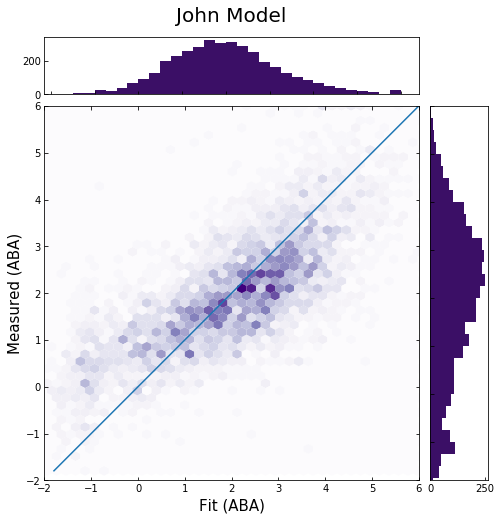

In [140]:
display(vhinge(predicted), actual, title="John Model")

In [141]:
print("r value is ", pearsonr(vhinge(predicted), actual)[0])

r value is  0.7301299063940148


In [110]:
#used to create the hadamard matrices
def flip_diagonal(M, diag):
    for i in range(M.shape[0]):
        r = i
        c = i + diag
        if 0 < r < M.shape[0] and 0 < c < M.shape[1]:
            M[r, c] *= -1
    return M

#builds an 12x12 hadamard matrix
def build_H12():
    H12 = np.ones((12, 12))
    for diag in [0, -1, 2, -3, -4, -5, 6, 7, 8, -9, 10]:
        H12 = flip_diagonal(H12, diag)
    return H12

#builds an 4x4 hadamard matrix
def build_H4():
    H4 = np.ones((4, 4))
    for diag in [0, -1, 2]:
        H4 = flip_diagonal(H4, diag)
    return H4

H4 = build_H4()
H12 = build_H12()

#think of data_matrix as input and output variable as output

#data row looks like
#D0 D1 D2 ... D21 I0 I1 I2 ... I21 IA IC IG IT  R0 R1 ... R21 R_AC R_AG R_AT R_CA R_CG R_CT ...

def func_eval_hadamard(vec, coords, perfect_seq_len=22):
    deletions= vec[:perfect_seq_len]
    insertions = vec[perfect_seq_len:2*perfect_seq_len]
    replacements = vec[perfect_seq_len*2:perfect_seq_len*3]
    
    ins_vals = np.array([4] + list(vec[perfect_seq_len*3:perfect_seq_len*3+3]))
    ins_weights = 1/4 * H4 @ ins_vals.T
    rep_vals = np.array([12] + list(vec[perfect_seq_len*3+3:perfect_seq_len*3+3+11]))
    rep_weights = 1/12* H12 @ rep_vals.T
    total_sum = 0
    for elt in coords:
        if elt[1] == "delete":
            total_sum += deletions[elt[0]]
        elif elt[1] == "replace":
            pos = elt[0]
            if perfect_sequence[pos] == "A" and elt[2] == "C":
                total_sum += replacements[pos]*rep_weights[0]
            elif perfect_sequence[pos] == "A" and elt[2] == "G":
                total_sum += replacements[pos]*rep_weights[1]
            elif perfect_sequence[pos] == "A" and elt[2] == "T":
                total_sum += replacements[pos]*rep_weights[2]
            elif perfect_sequence[pos] == "C" and elt[2] == "A":
                total_sum += replacements[pos]*rep_weights[3]
            elif perfect_sequence[pos] == "C" and elt[2] == "G":
                total_sum += replacements[pos]*rep_weights[4]
            elif perfect_sequence[pos] == "C" and elt[2] == "T":
                total_sum += replacements[pos]*rep_weights[5]
            elif perfect_sequence[pos] == "G" and elt[2] == "A":
                total_sum += replacements[pos]*rep_weights[6]
            elif perfect_sequence[pos] == "G" and elt[2] == "C":
                total_sum += replacements[pos]*rep_weights[7]
            elif perfect_sequence[pos] == "G" and elt[2] == "T":
                total_sum += replacements[pos]*rep_weights[8]
            elif perfect_sequence[pos] == "T" and elt[2] == "A":
                total_sum += replacements[pos]*rep_weights[9]
            elif perfect_sequence[pos] == "T" and elt[2] == "C":
                total_sum += replacements[pos]*rep_weights[10]
            elif perfect_sequence[pos] == "T" and elt[2] == "G":
                total_sum += replacements[pos]*rep_weights[11]
            else:
                print("something wrong in replacement!!")
        elif elt[1] == "insert":
            pos = elt[0]
            if elt[2] == "A":
                total_sum += insertions[pos]*ins_weights[0]
            elif elt[2] == "C":
                total_sum += insertions[pos]*ins_weights[1]
            elif elt[2] == "G":
                total_sum += insertions[pos]*ins_weights[2]
            elif elt[2] == "T":
                total_sum += insertions[pos]*ins_weights[3]
            else:
                print("something wrong with insertion")
        else:
            print("something wrong with the overall method")
    return total_sum

def create_vector_predictions_actuals_hadamard(vec,coords, output, perfect_sequence_len = 22):
    predictions = []
    actuals = output
    for coord in coords: 
        predictions.append(func_eval_hadamard(vec, coord, perfect_seq_len=perfect_sequence_len))
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return predictions, actuals

def loss_func_hadamard(vec, coords, output, l=0, perfect_sequence_len = 22):
    predictions, actuals = create_vector_predictions_actuals_hadamard(vec,coords, output, perfect_sequence_len=perfect_sequence_len)
    loss = np.linalg.norm(vhinge(predictions)-actuals) + l*np.linalg.norm(vec)
    #print(loss)
    return loss

In [120]:
#takes ~15-20 mins
res = minimize(lambda x: loss_func_hadamard(x,coords, output, l=0),
               np.random.normal(0,1,22*3+3+11)*2, method='BFGS', options={'maxiter':40})

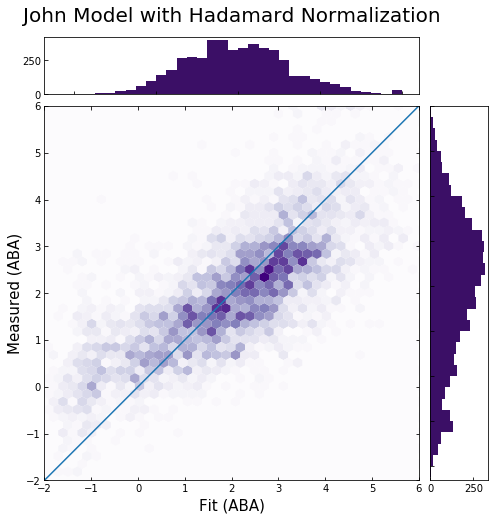

In [121]:
predicted, actual = create_vector_predictions_actuals_hadamard(res.x, coords, output)
display(vhinge(predicted), actual, title="John Model with Hadamard Normalization")

In [122]:
res.x

array([ 1.96819944,  1.87584106,  1.72672881,  2.22638525,  2.70811335,
        2.3383624 ,  2.27898615,  1.74643943,  1.70183499,  0.73722468,
        1.62226531,  0.50636146,  3.19283916,  0.47872264, -0.36222085,
       -1.37606236,  0.67016699,  0.48246629,  1.41064631,  1.0880357 ,
        1.08978915,  2.12600714,  1.3243491 ,  1.36962223,  1.16129524,
        1.75477714,  1.28699866,  1.65552581,  2.23074041,  1.1739592 ,
        1.45552518,  1.20914514,  0.68539861,  1.14111423,  0.87763321,
        0.39577935, -0.10164417, -0.54097041,  0.17338945,  0.9069345 ,
        0.08146762,  0.21104504,  0.1696216 ,  0.50231412,  2.45727595,
        2.70128574,  2.49248894,  1.93450468,  2.05722173,  1.45991195,
        1.75548643,  1.40668406,  2.10819221,  1.57044208,  0.56485852,
        0.80998234,  0.62427548,  0.53757258,  0.02610401, -0.73715171,
       -0.90114668,  0.58395437,  0.6077806 ,  0.88741385, -0.09789987,
        0.84319355, -0.13114491, -0.60315439, -0.7179096 ,  0.79

In [123]:
print("r value is", pearsonr(vhinge(predicted), actual)[0])

r value is 0.7526204810738714
